In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [2]:
data_df=pd.read_csv("data/diabetes.csv")
clean_data_df = data_df[
    (data_df['Glucose'] != 0) &
    (data_df['BloodPressure'] != 0) &
    (data_df['SkinThickness'] != 0) &
    (data_df['Insulin'] != 0) &
    (data_df['BMI'] != 0)
]

In [3]:
glucose = ctrl.Antecedent(np.arange(56, 198+1, 1), 'glucose')
age = ctrl.Antecedent(np.arange(21, 81+1, 1), 'age')
bmi = ctrl.Antecedent(np.arange(18.2, 67.1+0.1, 0.1), 'bmi')

prediction = ctrl.Consequent(np.arange(0, 1+0.05, 0.05), 'prediction')

# glucose
glucose['very low'] = fuzz.trapmf(glucose.universe, [0, 53, 69.5, 97.5])
glucose['low'] = fuzz.trapmf(glucose.universe, [56, 70.5, 97, 125.5])
glucose['medium'] = fuzz.trapmf(glucose.universe, [70, 98, 124.5, 162.5])
glucose['high'] = fuzz.trapmf(glucose.universe, [97.5, 125.5, 162, 200])
glucose['very high'] = fuzz.trapmf(glucose.universe, [124.5, 163, 200, 300])

# age
age['young'] = fuzz.trapmf(age.universe, [0, 18, 22, 33])
age['middle age'] = fuzz.trimf(age.universe, [21, 33, 44])
age['old'] = fuzz.trimf(age.universe, [33, 47, 67])
age['very old'] = fuzz.trapmf(age.universe, [47, 51, 82, 100])

# bmi
bmi['underweight'] = fuzz.trapmf(bmi.universe, [0, 0, 18, 21.8])
bmi['normal weight'] = fuzz.trimf(bmi.universe, [16, 21.8, 27.5])
bmi['overweight'] = fuzz.trimf(bmi.universe, [21.8, 27.5, 32.5])
bmi['obesity 1'] = fuzz.trimf(bmi.universe, [27.5, 32.5, 37.5])
bmi['obesity 2'] = fuzz.trimf(bmi.universe, [32.5, 37.5, 54])
bmi['obesity 3'] = fuzz.trapmf(bmi.universe, [37.5, 40, 68, 80])


# output
prediction['no'] = fuzz.trimf(prediction.universe, [0, 0, 0.8])
prediction['yes'] = fuzz.trimf(prediction.universe, [0.2, 1, 1])


/home/ting/Dev-Projects/Fuzzy-Logic-Diabetes/venv/lib/python3.8/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


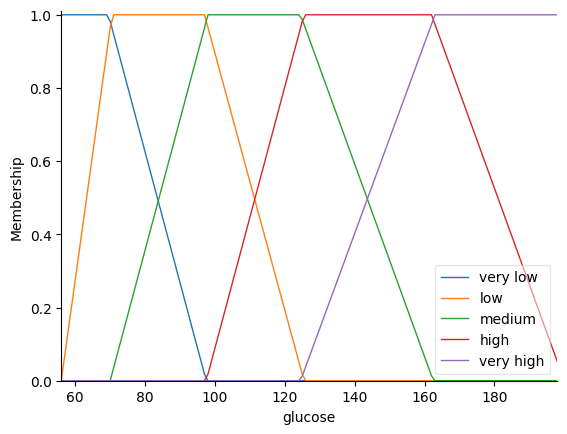

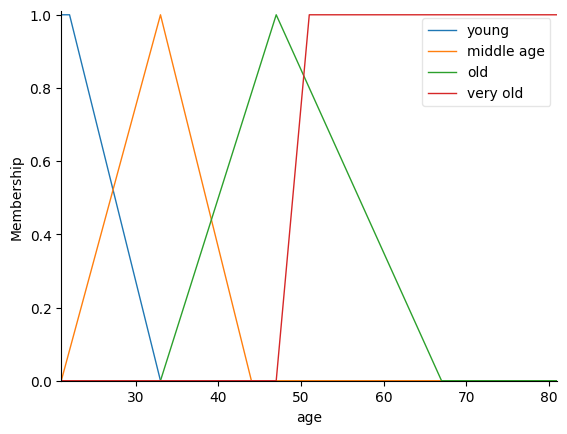

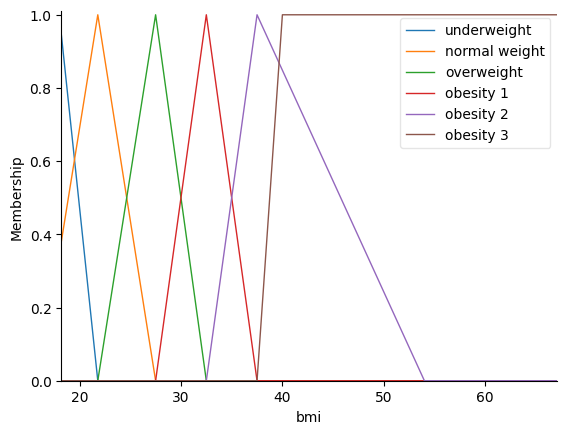

In [4]:
glucose.view()
age.view()
bmi.view()

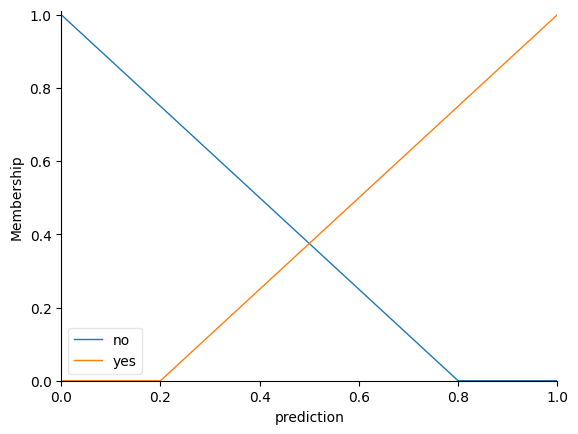

In [5]:
prediction.view()

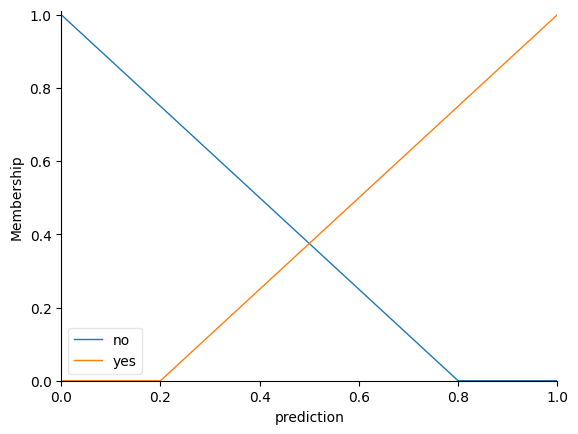

In [6]:
prediction.view()

In [7]:
rules = [
    # glucose, age, no
    ctrl.Rule(glucose['very low'] &
              (age['young'] | age['middle age'] | age['old']),
              prediction['no']),
    ctrl.Rule(glucose['low'] &
              (age['young'] | age['middle age']),
              prediction['no']),
    ctrl.Rule(glucose['medium'] &
              (age['young'] | age['middle age']),
              prediction['no']),
    ctrl.Rule(glucose['high'] &
              age['young'],
              prediction['no']),

    # glucose, age, yes
    ctrl.Rule(glucose['high'] &
              age['old'],
              prediction['yes']),
    ctrl.Rule(glucose['very high'] &
              (age['young'] | age['middle age'] | age['very old']),
              prediction['yes']),

    # glucose, bmi, no
    ctrl.Rule(glucose['very low'] &
              (bmi['normal weight'] | bmi['overweight'] | bmi['obesity 2']),
              prediction['no']),
    ctrl.Rule(glucose['low'] &
              (bmi['underweight'] | bmi['normal weight'] | bmi['overweight'] | bmi['obesity 1'] | bmi['obesity 2']),
              prediction['no']),
    ctrl.Rule(glucose['medium'] &
              ( bmi['normal weight'] | bmi['overweight'] | bmi['obesity 2']),
              prediction['no']),
    ctrl.Rule(glucose['high'] &
              (bmi['normal weight']),
              prediction['no']),

    # glucose, bmi, yes
    ctrl.Rule(glucose['very high'] &
              (bmi['normal weight'] | bmi['overweight'] | bmi['obesity 1'] | bmi['obesity 2']),
              prediction['yes']),
]

prediction_ctrl = ctrl.ControlSystem(rules)
prediction_inference = ctrl.ControlSystemSimulation(prediction_ctrl)


In [8]:
prediction_inference.input['glucose'] = clean_data_df['Glucose'].to_numpy()
prediction_inference.input['age'] = clean_data_df['Age'].to_numpy()
prediction_inference.input['bmi'] = clean_data_df['BMI'].to_numpy()

prediction_inference.compute()
result_np = prediction_inference.output['prediction']
# prediction.view(sim=prediction_inference)

In [9]:
output_np = np.where(result_np > 0.51, 1, 0)
gt_np = clean_data_df['Outcome'].to_numpy()
total_sample = gt_np.shape[0]
accurate_sample = (output_np == gt_np).sum()
accuracy = (accurate_sample / total_sample) * 100
print(total_sample)
print(accurate_sample)
print(accuracy)

392
314
80.10204081632652
